In [1]:
import fitz
import pandas as pd
import numpy as np
import os
import re
from collections import Counter

## Read Dataframe

In [2]:
def read_recommendation_clean(file_name):
    import nltk
    from nltk.util import bigrams, trigrams, ngrams
    # open document
    pdf_document = fitz.open(file_name)
    text = ''
    # extraction markers
    start_extraction = False
    end_extraction = False
    start_marker = "1 \nRecommendations"
    end_marker1 = "Why the committee made these recommendations"
    end_marker2 = "2 \nThe technology"
    page_marker = "© NICE 2023"
    
    # Loop through the pages and extract text between "1 Recommendation" and "2 The technology"
    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        title_text = page_text[:page_text.find(")",0) + 1]
        # Check for the start marker
        if start_marker in page_text and '1.1' in page_text:
            start_extraction = True
            # Remove text before the start marker
            page_text = page_text.split('1.1', 1)[-1]
        if start_extraction == False:
            continue
        # Check for the end marker
        if end_marker1 in page_text:
            # Remove text after the end marker
            page_text = page_text.split(end_marker1, 1)[0]
            # Stop extraction
            start_extraction = False
        elif end_marker2 in page_text:
            # Remove text after the end marker
            page_text = page_text.split(end_marker2, 1)[0]
            # Stop extraction
            start_extraction = False
        # remove the page footer"
        else:
            page_text = page_text.split(page_marker, 1)[0]
        #if title_text in page_text:
            #page_text = page_text.replace(title_text,'')
        page_text = re.sub(r'[^a-zA-Z -]', '', page_text)
        text += page_text
    return text

## Find Common Keywords

In [3]:
def extract_row_grams(row,title,content,num_gram):
    import nltk
    import numpy as np
    from nltk.util import ngrams
    # tokenize content and title
    tokenized_title = nltk.word_tokenize(row[title].lower().replace('-', ' '))
    tokenized_content = nltk.word_tokenize(row[content].lower().replace('-', ' '))
    # Create ngrams for both content and title
    content_grams = list(ngrams(tokenized_content, num_gram))
    title_grams = list(ngrams(tokenized_title,num_gram))

    # Find ngrams in tokenized_content but not in tokenized_title
    filtered_content_grams = [gram for gram in content_grams if gram not in title_grams]
    return list(set(filtered_content_grams))

def extract_grams(df,num_gram):
    df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
    gram_lst = []
    for r in df['ngrams']:
        for j in r:
            gram_lst.append(j)
    return Counter(gram_lst)

In [4]:
# def extract_grams(df,num_gram):
#     import nltk
#     from nltk.util import ngrams
#     # tokenize content and title
#     tokenized_title = [word.lower() for text in df['title'].apply(lambda x: x.replace('-',' ')) for word in nltk.word_tokenize(text)]
#     tokenized_content = [word.lower() for text in df['Content'] for word in nltk.word_tokenize(text)]

#     # Create ngrams for both content and title
#     content_grams = list(ngrams(tokenized_content, num_gram))
#     title_grams = list(ngrams(tokenized_title,num_gram))

#     # Find ngrams in tokenized_content but not in tokenized_title
#     filtered_content_grams = [gram for gram in content_grams if gram not in title_grams]
    
#     # Find the top ngrams
#     gram_counts = Counter(filtered_content_grams)
#     return gram_counts

In [5]:
def find_unique_dict(o_dict, whole_dict):
    r_dict = {}
    # build dict with grams as key and (count in this category, count in others) as value
    for key, value in o_dict.items():
        r_dict[key] = (value, whole_dict[key]-value)
    # sort dict based on uniqueness and count
    sorted_dict = dict(
        sorted(r_dict.items(), key=lambda item: (item[1][1], -item[1][0])))
    return sorted_dict

In [6]:
def find_unique_grams(df,num_gram, num_top):
    # get the catergories of judgement
    cat = df['JNJ Classification (manual)'].value_counts().index.tolist()
    cat_lst = []
    for c in cat:
        # get most common k n-grams
        df_c = df[df['JNJ Classification (manual)'] == c]
        gram_cnt = extract_grams(df_c,num_gram)
        top_gram = gram_cnt.most_common(num_top)
        # transform into dict
        top_gram_dict = {t[0]:t[1] for t in top_gram}
        cat_lst.append(top_gram_dict)
    # get the number of occurances of grams in all categories
    combined_dict = dict(extract_grams(df,num_gram))
    # add uniqueness to gram_dict of each category
    cat_u_lst = []
    for d in cat_lst:
        u_dict = find_unique_dict(d, combined_dict)
        # put gram and the count together into list 
        u_lst = [(key, value) for key, value in u_dict.items()]
        cat_u_lst.append(u_lst)
    # build dataframe
    cat_dict = {key: value for key, value in zip(cat, cat_u_lst)}
    return pd.DataFrame(cat_dict)

In [7]:
def get_probmat(lab_df):
    import numpy as np
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.linear_model import LogisticRegression
    
    topgrams = find_unique_grams(lab_df,3,10)
    keep = topgrams[topgrams.applymap(lambda x: x[1][0] >= x[1][1])]

    # Reshape the DataFrame using melt
    grams_df = pd.melt(keep, value_vars=['Not Supporting Routine Use', \
                                           'Routine Use', \
                                           'Treatment Option'], 
                          value_name='content', var_name='label')
    grams_df = grams_df.dropna()
    grams_df['content'] = grams_df['content'].apply(lambda x: x[0])
    grams_df['tuple string'] = grams_df['content'].apply(lambda x: " ".join(x))

    X = grams_df['content']
    y = grams_df['label']
     
    X_text = [' '.join(words) for words in X]
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(X_text)
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    logreg.fit(X_bow, y)
    
    prob_mat = logreg.predict_proba(X_bow) 
    
    grams_df['prob_Not Supporting Routine Use'] = prob_mat[:, 0]
    grams_df['prob_Routine Use'] = prob_mat[:, 1]
    grams_df['prob_Treatment Option'] = prob_mat[:, 2]
    
    return grams_df

In [10]:
topgrams = find_unique_grams(lab_df,5,10)
topgrams

/var/folders/3k/09j56lvn3nb56h3g85t9x0vm0000gn/T/ipykernel_23015/2145720216.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/3k/09j56lvn3nb56h3g85t9x0vm0000gn/T/ipykernel_23015/2145720216.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/3k/09j56lvn3nb56h3g85t9x0vm0000gn/T/ipykernel_23015/2145720216.py

,Treatment Option,Not Supporting Routine Use,Routine Use
0,"((should, be, considered, as, an), (10, 0))","((not, enough, good, quality, evidence), (7, 0))","((by, an, average, of, per), (2, 0))"
1,"((be, considered, as, an, option), (9, 0))","((good, quality, evidence, to, support), (6, 0))","((symptoms, reduce, in, the, first), (1, 0))"
2,"((is, recommended, as, an, option), (9, 0))","((quality, evidence, to, support, the), (6, 0))","((first, months, cost, modelling, estimates), ..."
3,"((considered, as, an, option, for), (8, 0))","((to, support, the, case, for), (14, 1))","((is, recommended, as, a, cost), (2, 4))"
4,"((as, an, option, for, people), (6, 0))","((support, the, case, for, routine), (13, 1))","((a, cost, saving, option, for), (2, 4))"
5,"((is, supported, by, the, evidence), (11, 1))","((the, case, for, routine, adoption), (13, 1))","((as, a, cost, saving, option), (2, 6))"
6,"((the, case, for, adopting, the), (11, 1))","((evidence, to, support, the, case), (11, 1))","((recommended, as, a, cost, saving), (2, 6))"
7,"((supports, the, case, for, adopting), (8, 2))","((is, recommended, to, address, uncertainties)...","((is, cost, saving, compared, with), (2, 7))"
8,"((evidence, supports, the, case, for), (8, 2))","((recommended, to, address, uncertainties, abo...","((supports, the, case, for, adopting), (2, 8))"
9,"((is, cost, saving, compared, with), (7, 2))","((routine, adoption, in, the, nhs), (7, 1))","((evidence, supports, the, case, for), (2, 8))"


In [9]:
# Read Labelled Data from csv
lab_df = pd.read_csv('jnj_judgement.csv')
#lab_df.set_index(lab_df.columns[0], inplace=True)
lab_df = lab_df[['title','JNJ Classification (manual)']].dropna()
lab_df['Content'] = lab_df['title'].apply(lambda f: read_recommendation_clean("./MTG/Files/" + f + "/" + f))
lab_df['Not Supporting Routine Use'] = ''
lab_df['Routine Use'] = ''
lab_df['Treatment Option'] = ''

In [11]:
grams_df = get_probmat(lab_df)
grams_df

/var/folders/3k/09j56lvn3nb56h3g85t9x0vm0000gn/T/ipykernel_23015/2145720216.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/3k/09j56lvn3nb56h3g85t9x0vm0000gn/T/ipykernel_23015/2145720216.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ngrams'] = df.apply(extract_row_grams, args=('title', 'Content', num_gram), axis=1)
/var/folders/3k/09j56lvn3nb56h3g85t9x0vm0000gn/T/ipykernel_23015/2145720216.py

,label,content,tuple string,prob_Not Supporting Routine Use,prob_Routine Use,prob_Treatment Option
0,Not Supporting Routine Use,"(support, the, case)",support the case,0.672890,0.037558,0.289552
1,Not Supporting Routine Use,"(case, for, routine)",case for routine,0.662124,0.037825,0.300051
2,Not Supporting Routine Use,"(to, support, the)",to support the,0.821545,0.030351,0.148104
3,Not Supporting Routine Use,"(for, routine, adoption)",for routine adoption,0.725180,0.040655,0.234166
4,Not Supporting Routine Use,"(evidence, to, support)",evidence to support,0.865004,0.031943,0.103053
5,Not Supporting Routine Use,"(to, address, uncertainties)",to address uncertainties,0.876909,0.031918,0.091172
6,Not Supporting Routine Use,"(address, uncertainties, about)",address uncertainties about,0.793028,0.045576,0.161395
7,Not Supporting Routine Use,"(research, is, recommended)",research is recommended,0.765618,0.044154,0.190228
8,Not Supporting Routine Use,"(is, recommended, to)",is recommended to,0.853419,0.031991,0.114590
10,Routine Use,"(an, average, of)",an average of,0.183115,0.607047,0.209838


In [16]:
def labdf_prob(content, lab_df, grams_df, idx):
    tuple_id = []
    for i in range(grams_df.shape[0]):
        if grams_df['tuple string'].iloc[i] in content:
            tuple_id.append(i)
    
    lab_df['Not Supporting Routine Use'].loc[idx] = grams_df.iloc[tuple_id]['prob_Not Supporting Routine Use'].mean()
    lab_df['Routine Use'].loc[idx] = grams_df.iloc[tuple_id]['prob_Routine Use'].mean()
    lab_df['Treatment Option'].loc[idx] = grams_df.iloc[tuple_id]['prob_Treatment Option'].mean()
    

In [17]:
def fill_labdf(lab_df):
    for i in lab_df.index.values:
        labdf_prob(lab_df['Content'].loc[i], lab_df, grams_df, i)

    return lab_df

In [18]:
def fill_decision(lab_df_withprob):
    lab_df_withprob = lab_df_withprob.copy()
    lab_df_withprob['decision'] = ''

    for i in lab_df.index.values:
        if lab_df_withprob.loc[i].isna().any():
            lab_df_withprob['decision'].loc[i] = 'undecided'
        else:
            lab_df_withprob['decision'].loc[i] = lab_df_withprob.loc[i][['Not Supporting Routine Use', 'Routine Use', \
                         'Treatment Option']].sort_values()[::-1].index[0]
    return lab_df_withprob

In [19]:
lab_df_withprob = fill_labdf(lab_df)
decisiondf = fill_decision(lab_df_withprob)
decisiondf

,title,JNJ Classification (manual),Content,Not Supporting Routine Use,Routine Use,Treatment Option,ngrams,decision
0,3c-patch-for-treating-diabetic-foot-ulcers-pdf...,Not Supporting Routine Use,C Patch is not recommended as a cost-saving o...,NaN,NaN,NaN,"[(c, patch, is), (a, cost, saving), (is, not, ...",undecided
1,alphastim-aid-for-anxiety-disorders-pdf-643721...,Not Supporting Routine Use,Alpha-Stim AID shows promise for managing anx...,0.723523,0.039958,0.23652,"[(managing, anxiety, disorders), (to, address,...",Not Supporting Routine Use
2,ambu-ascope4-broncho-for-use-in-unexpected-dif...,Treatment Option,The case for adopting the Ambu aScope Broncho...,0.163285,0.054037,0.782678,"[(multiple, use, endoscopes), (the, ambu, asco...",Treatment Option
3,ambulight-pdt-for-the-treatment-of-nonmelanoma...,Not Supporting Routine Use,Ambulight PDT offers a means of delivering ph...,0.299344,0.049421,0.651235,"[(increase, of, nhs), (pdt, offers, a), (and, ...",Treatment Option
4,aposhealth-for-knee-osteoarthritis-pdf-6437224...,Not Supporting Routine Use,AposHealth is recommended as a cost-saving op...,0.759882,0.050372,0.189747,"[(osteoarthritis, in, adults), (replacement, s...",Not Supporting Routine Use
...,...,...,...,...,...,...,...,...
60,uroshield-for-preventing-catheterassociated-ur...,Not Supporting Routine Use,More research is recommended on UroShield for...,0.773442,0.051446,0.175112,"[(be, comparative, and), (more, research, is),...",Not Supporting Routine Use
61,vibratip-for-testing-vibration-perception-to-d...,Not Supporting Routine Use,VibraTip shows potential to improve the detec...,0.685263,0.039442,0.275295,"[(to, address, uncertainties), (available, vib...",Not Supporting Routine Use
62,virtual-touch-quantification-to-diagnose-and-m...,Treatment Option,The case for adopting Virtual Touch Quantific...,0.15597,0.059992,0.784038,"[(liver, biopsy, is), (cost, saving, for), (pe...",Treatment Option
63,xpress-multi-sinus-dilation-system-for-treatin...,Treatment Option,The case for adopting the XprESS multi-sinus ...,0.161966,0.053573,0.78446,"[(patients, xpress, works), (to, a, rapid), (f...",Treatment Option


In [20]:
prob_df = decisiondf[['Not Supporting Routine Use', 'Routine Use', 'Treatment Option']]
y_prob = prob_df.max(axis=1)

In [21]:
decisiondf.to_csv('decision.csv', index=True)

In [22]:
np.sum(decisiondf['JNJ Classification (manual)'] == decisiondf['decision']) / decisiondf.shape[0]

0.7692307692307693

In [23]:
from sklearn.metrics import classification_report

In [24]:
y = decisiondf['JNJ Classification (manual)']
predictions = decisiondf['decision']

In [25]:
print(classification_report(y, predictions, zero_division=0))

                            precision    recall  f1-score   support

Not Supporting Routine Use       0.86      0.83      0.84        23
               Routine Use       0.00      0.00      0.00         5
          Treatment Option       0.84      0.84      0.84        37
                 undecided       0.00      0.00      0.00         0

                  accuracy                           0.77        65
                 macro avg       0.43      0.42      0.42        65
              weighted avg       0.78      0.77      0.78        65



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

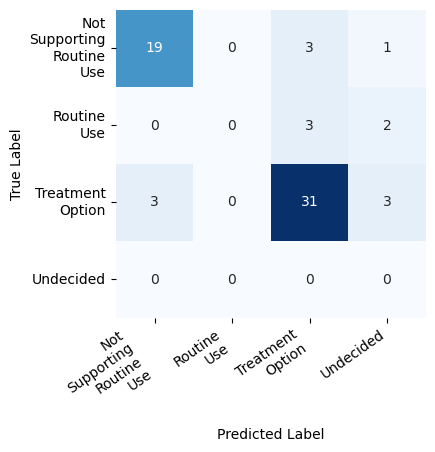

In [50]:
# Calculate confusion matrix
cm = confusion_matrix(y, predictions)

plt.figure(figsize=(4, 4))

x_labels = ['Not Supporting Routine Use', \
                         'Routine Use', \
                        'Treatment Option',\
                        'Undecided']

# Wrap x-axis labels
wrapped_labels = [textwrap.fill(label, width=10) for label in x_labels]

# # Create a heatmap
# ax =sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=['Predicted Not Supporting Routine Use', \
#                          'Predicted Routine Use', \
#                         'Predicted Treatment Option',\
#                         'Predicted Undecided'],
#             yticklabels=['Actual Not Supporting Routine Use', \
#                          'Actual Routine Use', \
#                         'Actual Treatment Option',\
#                         'Actual Undecided'])

ax =sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=wrapped_labels, 
            yticklabels=wrapped_labels)
# Create a heatmap using seaborn
# ax = sns.heatmap(data, xticklabels=wrapped_labels, cmap='viridis')



# Rotate x-axis labels
#plt.xticks(rotation=65, ha='right')

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')


# Rotate y-axis labels
plt.yticks(rotation=0)


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [113]:
predictions.value_counts()

Treatment Option              37
Not Supporting Routine Use    22
undecided                      6
Name: decision, dtype: int64

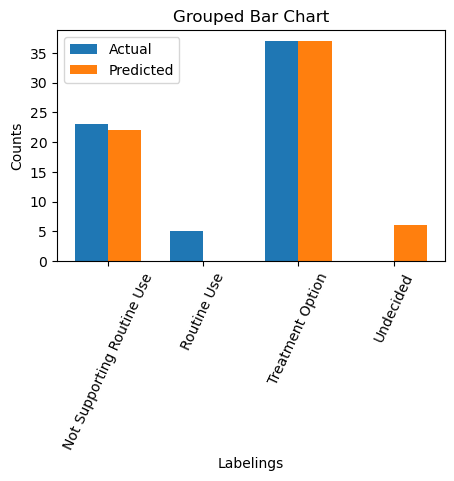

In [51]:
# Example data
categories = ['Not Supporting Routine Use', 'Routine Use', 'Treatment Option', 'Undecided']
y_values = np.array([23, 5, 37, 0])
predict_values = np.array([22, 0, 37, 6])

# Set the width of the bars
bar_width = 0.35

# Create an array of indices for each category
ind = np.arange(len(categories))

plt.figure(figsize=(5, 3))

# Plot the first set of bars
plt.bar(ind, y_values, width=bar_width, label='Actual')

# Plot the second set of bars next to the first set
plt.bar(ind + bar_width, predict_values, width=bar_width, label='Predicted')

# Rotate x-axis labels
plt.xticks(rotation=65)

# Add labels and title
plt.xlabel('Labelings')
plt.ylabel('Counts')
plt.title('Grouped Bar Chart')

# Add legend
plt.legend()

# Set the x-axis ticks to the middle of the group bars
plt.xticks(ind + bar_width / 2, categories)

# Show the plot
plt.show()

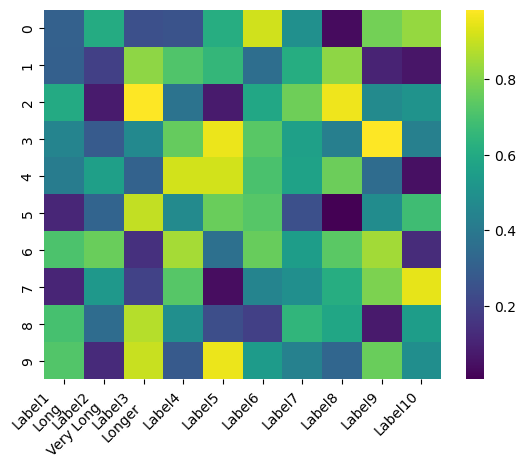

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Sample data
data = np.random.rand(10, 10)

# Sample x-axis labels
x_labels = ['Label1 Long', 'Label2 Very Long', 'Label3 Longer', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8', 'Label9', 'Label10']

# Wrap x-axis labels
wrapped_labels = [textwrap.fill(label, width=10) for label in x_labels]

# Create a heatmap using seaborn
ax = sns.heatmap(data, xticklabels=wrapped_labels, cmap='viridis')

# Rotate and adjust x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the heatmap
plt.show()
